# Data Programming

## Report contents
- Inroduction and context
- Brief description of data
- High level description of data
    - Where it has come from 
    - Why is this data relevant
- Summary of key findings and insights
- Some discussion and critical analysis
- Conclusions and further work
- Rreferences


## Introduction and context
This project report is an exploratory data analysis of the academic journal Frontiers with a focus on the rise in popularity of neuroscience as an academic discipline. According to the Frontiers website (https://www.frontiersin.org), it is the 3rd most cited and the 6th largest publisher with 1.9 billion article views and downloads. Presumably this is ranked against other journals worldwide however this is not explicitly stated on the site. Frontiers also have 3 journals ranked amongst the top 20 journals in the field of neurology measured by google for 2022 according to this independent report (https://www.immunofrontiers.com/top-20-neuroscience-journals-of-2022).

Frontiers is open access and has little to no restrictions with regards to the use of its website and published content. It also has a fairly uniform and clearly laid out website design which makes it an ideal candidate web scraping and therefore data collection. It also contains multiple journals on the topic of neuroscience. Using the search feature on the website (https://www.frontiersin.org/journals?items=&query=neuroscienceit) brings back 24 different journals either on or closely related to neuroscience. They also claim that some of these neuroscience journals are among the most cited in the world.
Overall, this makes it a good candidate for a data analysis on this topic.

I would like to start the analysis with the numerical meta data available for each journal to build an understanding of the journal as a whole and then use that to help inform and guide a more detailed analysis of the neuroscience journals themselves. I would like to collect and analyse data on the type of publications being produced in the neurosceince journals and also analyse some of the text for common words (e.g titles, abstracts, and whole artivles) and sentiement.

Although Frontiers is the name of the journal, it is really a collection journals with the majority prefixed with the title "Frontiers in" and then the name of the field. For example, Frontiers in Aerospace Engineering. Therefore, in this report Frontiers will refer to the collection of journals and organisation as a whole while the use of the word journal will refer to the specific journal or journals in question.

## Step 1: Data Aquisition

First of all we will take a look at the jouranl metadata from the list of all journals available at https://www.frontiersin.org/journals. This will hopefully provide us with some information about the publications overall and also where neuroscience fits into it.

The available data we will collect is the following.
- journal name
- sections
- articles
- article views
- IF (Impact Factor)
- citescore

## NOTE: Sometimes not all the data gets captured and you have to run the notebook again

In [423]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import re

#### Scraping the webpage
This webpage has a dynamically loading scroll feature and so the first thing we need to do is scroll to the bottom of the page
so all of the data can be scraped. This task can be automated using selenium. A sleep command at the end makes sure all the content has time to load and the fully loaded webpage is then captured in the soup variable using BeautifulSoup.

In [424]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.frontiersin.org/journals")
driver.execute_script("window.scrollBy(0,document.body.scrollHeight)")
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')

#### Retrieving the journal information
Next we want to retrieve each journal and its metadata information from the page. This information is contained in the "JournalCard__info" div's of the webpage. I have retrieved these and stored them in a list.

In [425]:
def get_journals(soup):
    journal_info = soup.find_all('div', class_='JournalCard__info')
    journals = []
    for journal in journal_info:
        journals.append(journal)
    return journals

## Step 2: Formatting and checking the data

#### Extracting each journals name and metrics
Now we can extract the information we need from each each journal card. The data will be formatted into a dictionary of dictionaries with the journal title as the key and the journal metrics being the values. These values are another dictionary where the metric title such as "article views" is the key and the corresponding number is the value. Since the article metric comes in as a complete string eg. "article views 150" they will be split and reformatted in the split metric function.

Some of the journals are new which is indicated by the word New at the end. I will leave this for now and deal with it later in the cleaning process if necessary as it could be useful to have seperatley.

example {'Frontiers in Aerospace Engineering New': {'sections': 5.0, 'articles': 10.0}

This data structure was chosen because it is very easy to convert it to a pandas dataframe.

The metric_to_dict function constructs the metric dictionary using the split_metric function to first convert all the string values that are numbers to floats and make sure the correct metric name is assigned to the correct value. Because the numbers are strings I used regex to identify any floats and also removed the commas used in numbers like '37,456,234'. Trailing spaces in the journal names were also removed.

Additionally there is a description of the journal and information reguarding the chief editor and the institution they are associated with. For simplicity I have not included these yet, and chosen to deal with the numerical data first, however they may contain some interesting insights and can always be added at a later date as they were captured in the soup object. 

In [426]:
def split_metric(metric, keys, values):
    is_float = re.compile("^[0-9]*.[0-9]*$")
    if metric.text:
        for data in metric.text.split(): # split the metric strings up so they can be put in dictionaries
            item = data.replace(",", "")
            if item != "views":
                if item.isdigit() or is_float.match(item): # check for numbers
                    values.append(float(item))
                else:
                    keys.append("article views" if item == "article" else item) # matches article views to the correct metric


def metric_to_dict(metrics):
    keys = [] # lists to store metric keys and values
    values = []
    for metric in metrics:
        split_metric(metric, keys, values)
    return dict(zip(keys, values)) # combine metrics back with thier values once they have been split and cleaned. 


def get_journal_data(journals):
    journal_data = {}
    for journal in journals:
        title = journal.find('h2', class_='JournalCard__title')
        metrics = journal.find_all('span', class_='JournalCard__data')
        journal_data[title.text.strip()] = metric_to_dict(metrics) # brings all the data together
    return journal_data

#### Converting to pandas DataFrame
Now these values can be translated into a pandas dataframe. To make the data more interpretable the dataframe has been transposed so the journal metrics are the column headings and the journal name is the row index as each journal name is unique.

In [427]:
df = pd.DataFrame(get_journal_data(get_journals(soup)))
df_transpose = df.transpose()
df_describe = df_transpose.copy()

#### Checking the data is correct
Looking at the shape of our dataframe and checking the website confirms we have captured all journals from the Frontiers webpage (There are currently 184 however i have noticed it does fluctuate as journals are added and taken down). This check could also be autom automated using the data from the scraped page.

I also did some spot checks of the data to confirm that the journal title and metrics were being assigned correctly. Using the DataFrame.to_dict() function seemed to cut off the last 8 entries but the standard DataFrame() with a transopose worked fine.

The data should contain no values less than zero so i ran a check for this.

In [550]:
print("shape of the data =", df_describe.shape)
print("Negative values in data =", (df_describe < 0).any().any())

shape of the data = (184, 6)
Negative values in data = False


#### First look at the data
Using the describe function we can see immediatley that there is a lot of missing values in this dataset. Citations, IF, and citescore are all more than half empty.

Another noticeable feature of this data is the high standard deviation for articles, article views and citations. This indicates that the journals have very different numbers of views and that its likley some journals get the majority of the attention while others get very little. This could also be due to the size of the research community for that field or how recently that particular journal was established. This also brings with it a higher possiblity of this data being non-normaly distributed which could make certain statistical analysis more difficult. 

We can also see that the max values are large compared to the the mean implying one or some of the journals being very popular and possibly having a large influence on these statistics.

In [429]:
df_describe.describe().round(decimals=1)

,sections,articles,article views,citations,IF,citescore
count,163.0,162.0,108.0,61.0,47.0,65.0
mean,9.5,2395.2,20305189.0,71856.4,4.9,4.4
std,5.9,5391.4,41818699.8,113103.8,1.3,2.2
min,4.0,1.0,100074.0,1186.0,2.6,0.7
25%,5.5,36.8,570935.2,7661.0,3.7,2.8
50%,8.0,196.0,2686905.0,28190.0,4.8,4.2
75%,12.0,1474.2,20931499.8,81599.0,6.0,5.4
max,33.0,34134.0,297348066.0,518016.0,8.8,9.8


#### More checks
Comparing some of the max values with the website shows they have been collected correctly.

In [553]:
df_describe.loc[df_describe["article views"] == 297348066.0]
df_describe.loc[df_describe["citations"] == 518016.0] 

,sections,articles,article views,citations,IF,citescore
Frontiers in Microbiology,17.0,27572.0,175078081.0,518016.0,6.064,8.2


## Step 3: Cleaning the data

#### Quantifying the missing data
Now lets deal with the mising data.

Since the dataset is 181 x 6 = 1086 datapoints (at this time of running) and we are missing 484. This means around 45% of the toatal dataset is missing. This missing data is the article metrics.

In [431]:
print(df_describe.isnull().sum())
print("toatl =", df_describe.isnull().sum().sum())

sections          21
articles          22
article views     76
citations        123
IF               137
citescore        119
dtype: int64
toatl = 498


#### Approach to missing data
I can see from the website that many of the journals dont have a complete set of metrics. Some journals have articles with many citations such as those in Frontiers in virology but the citation metric is missing from the journal.

Some of this missing data can be explained because many journals are new (indicated by the word "new"). These journals, such as Frontiers in Aerospace Engineering only have 10 articles and checking on the website shows that none of them have been cited yet.

Sections are specific sub topics of that journal and so if a NaN is present we can assume that journal has no sections and can be replaced with a 0.

Similarly with Impact Factor and citescore we can replace all NaN values with 0 as this metric is an average of a journals citations over time. We know that many of our journals are new and so would be unlikley to have aquired a score so we can set it to 0 for now.

These can be used as some basic huristics to handle the NaN values in this data set
1. New journals can have thier NaN values changed to 0
2. Established journals with missing scores can be given metric values proportional to thier other metrics if available. 
3. If sections is NaN it chan be changed to 0

In [432]:
display(df_describe)

,sections,articles,article views,citations,IF,citescore
Frontiers in Aerospace Engineering New,5.0,10.0,NaN,NaN,NaN,NaN
Frontiers in Aging,8.0,208.0,687201.0,NaN,NaN,NaN
Frontiers in Aging Neuroscience,6.0,5339.0,33761154.0,82277.0,5.702,6.4
Frontiers in Agronomy,7.0,269.0,654748.0,NaN,NaN,0.9
Frontiers in Allergy,13.0,252.0,477714.0,NaN,NaN,NaN
...,...,...,...,...,...,...
Frontiers in Veterinary Science,19.0,6081.0,30874692.0,28190.0,3.471,3.3
Frontiers in Virology,10.0,141.0,694342.0,NaN,NaN,NaN
Frontiers in Virtual Reality,6.0,394.0,1194346.0,NaN,NaN,NaN
Frontiers in Water,9.0,504.0,1092680.0,NaN,NaN,1.2


#### Identifying new journals
To make new journals easier to identify I have made a new column "is new" populated with either "YES" or "NO". This uses the word new found in the title of journals. We can see that its almost 50/50 new to established journals. However we do not know the exact crtiera for what makes a journal new or not new in frontiers.

In [569]:
df_handel_nulls = df_describe.copy()
is_new = []
for title in df_handel_nulls.index.values:
    if "New" in title:
        is_new.append("YES")
    else:
        is_new.append("NO")
        
df_handel_nulls["is new"] = is_new
df_handel_nulls["is new"].value_counts()

NO     95
YES    89
Name: is new, dtype: int64

Next we can use this column to locate all the new journals that have NaN values and replace them with zeros.

In [434]:
df_handel_nulls.loc[df_handel_nulls["is new"] == "YES"] = df_handel_nulls.fillna(0)

,sections,articles,article views,citations,IF,citescore,is new
Frontiers in Aerospace Engineering New,5.0,10.0,0.0,0.0,0.0,0.0,YES
Frontiers in Amphibian and Reptile Science New,4.0,0.0,0.0,0.0,0.0,0.0,YES
Frontiers in Analytical Science New,6.0,44.0,0.0,0.0,0.0,0.0,YES
Frontiers in Anesthesiology New,5.0,12.0,0.0,0.0,0.0,0.0,YES
Frontiers in Antibiotics New,4.0,14.0,0.0,0.0,0.0,0.0,YES
...,...,...,...,...,...,...,...
Frontiers in the Internet of Things New,6.0,6.0,0.0,0.0,0.0,0.0,YES
Frontiers in Thermal Engineering New,8.0,24.0,0.0,0.0,0.0,0.0,YES
Transplant International New,0.0,0.0,0.0,0.0,0.0,0.0,YES
Frontiers in Transplantation New,8.0,18.0,0.0,0.0,0.0,0.0,YES


#### NOTE: couldnt get command working

This is a command i was working with for not changing the IF and citescore when replacing the new journals metrics but was getting some very strange behaviour. I thought it would be nice to keep the NaN for IF and citescore as on second thoughts it might make more sense but i couldnt get this to work. 

df_handel_nulls = df_handel_nulls.loc[df_handel_nulls["is new"] == "YES"] = df_handel_nulls.fillna({'sections':0,'articles':0,'article views':0,'citations':0})

This has reduced our missing data to around 11%

In [435]:
df_handel_nulls.isnull().sum().sum()

124

In [436]:
df_handel_nulls.isnull().sum()

sections         10
articles          0
article views     0
citations        36
IF               48
citescore        30
is new            0
dtype: int64

#### Update sections, IF and citescore  
Now we can update all the journals missing a section Impact factor and citescore metric to 0.

#### NOTE: i had to do these one after another otherwise i would get error messages that would stop the notebook

In [437]:
df_handel_nulls['sections'].fillna(0, inplace=True)
df_handel_nulls['IF'].fillna(0, inplace=True)
df_handel_nulls['citescore'].fillna(0, inplace=True)

In [438]:
df_handel_nulls.isnull().sum().sum()

36

#### Updating the citations metric

Citations is the next metric most likley to be able to be accuratley ammended. If there is a strong correlation between the amount of articles and article views a journal has and the number of citations this may be able to accuratley predict citations.

Looking at the correlation there is a lot of positive correlations which makes sense. As a journal grows you would expect each of these metrics to grow.

Citations are highly correlated with both article views and articles at 93%. This makes them equally powerful predictors of citations and so both suitable for a regression model.

However all the results in the table all seem correlated which is not suprising given the nature of academic journals and no P values to determine statistical significance have been included which could be a useful next step in a more detailed analysis.

In [439]:
df_handel_nulls.corr().round(decimals=2)

,sections,articles,article views,citations,IF,citescore
sections,1.00,0.72,0.63,0.57,0.60,0.50
articles,0.72,1.00,0.96,0.93,0.73,0.67
article views,0.63,0.96,1.00,0.93,0.63,0.59
citations,0.57,0.93,0.93,1.00,0.63,0.63
IF,0.60,0.73,0.63,0.63,1.00,0.89
citescore,0.50,0.67,0.59,0.63,0.89,1.00


#### Graphing citations

The Graphs show Frontiers in Psychology is a clear outlier when paired with article views and slightly less when paired with articles.

Its hard to make any assumptions because its only only one datapoint but this could be an indication that once a journal grows to a certain size in terms of articles and article views citations begin to drop off. Comparisons with other journals of similar size could be interesting to see if this is common. 

These graphs also illustrate how many new journals have been added the the frontiers publication as we have many that stack up near the lower ends of the graph.

NO     95
YES    89
Name: is new, dtype: int64

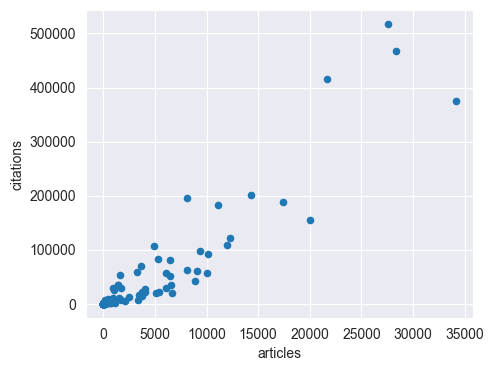

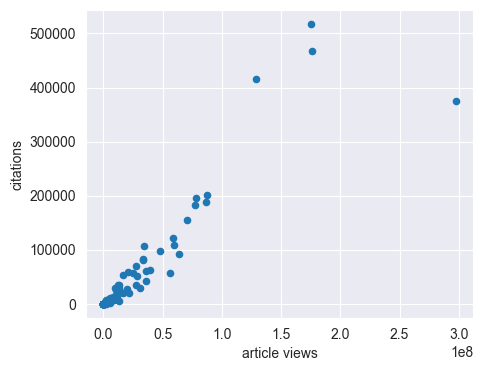

In [568]:
df_handel_nulls.plot(x="articles", y="citations", kind='scatter', figsize=[5, 4])
df_handel_nulls.plot(x="article views", y="citations", kind='scatter', figsize=[5, 4])

In [451]:
print(df_handel_nulls["articles"].idxmax())
print(df_handel_nulls["article views"].idxmax())

Frontiers in Psychology
Frontiers in Psychology


#### seaborn pairplot

We can visualise the rest of the correllations in a pairplot using seaborn to get a better idea of the relationshsips.

#### Setting up a regression model with articles and citations

The basic linear regression model from scikitlean can be used to predict citations using the articles data.

A train size of 0.3 seemed to yeild fairly consistent results for Rsqr between 60%-90% however the RMSE remained quite high likley because the influence of the large journals with many articles. However, there are not many datapoints and so i decided to keep them in anyway as the predictions the model produced ended up seeming quite good. 

The Rsqr is:  0.8468997273743974
The RMSE is:  35602.88733475761


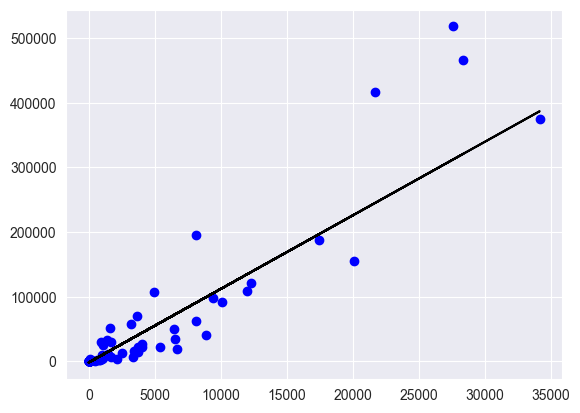

In [502]:
df_no_null_citations = df_handel_nulls.loc[df_handel_nulls["citations"].notnull()]

model = LinearRegression()

X = np.array(df_no_null_citations["articles"]).reshape(-1, 1)
y = np.array(df_no_null_citations["citations"]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The Rsqr is: ', r2)
print('The RMSE is: ', rmse)

y_pred = model.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')


#### Predicting citations with the regression model

Tthis regression model predicts the number of citations for each journal based on the number of articles they have. This method was probably a little overkill but comparing the predictions with other journals shows they are plausable numbers they might as well be used.

#### NOTE: It can be worth running the model a few times to get better values if the first run is not so good.
This is obviously a downside to using this technique in its current state. Good rule of thumb is you want the first value to be around 1000 and the last one to be around 10000 then its usually a good prediciton. Also make sure to take the absolute value to avoid any negative numbers.

In [503]:
df_null_citations = df_handel_nulls.loc[df_handel_nulls["citations"].isnull()]
X_predict = np.array(df_null_citations["articles"]).reshape(-1, 1)
predictions = model.predict(X_predict)

new_citations = pd.DataFrame(predictions.round())[0].tolist()

print(list(map(abs, new_citations)))

df_clean = df_handel_nulls.copy()
df_clean.loc[df_clean.citations.isnull(), 'citations'] = list(map(abs, new_citations))
display(df_clean)


[824.0, 1519.0, 1325.0, 1086.0, 585.0, 358.0, 1132.0, 3795.0, 405.0, 359.0, 2543.0, 1473.0, 722.0, 4466.0, 187.0, 7.0, 1758.0, 50.0, 86.0, 654.0, 949.0, 1291.0, 2236.0, 1974.0, 2827.0, 335.0, 984.0, 1553.0, 1598.0, 3158.0, 836.0, 642.0, 62.0, 2941.0, 4193.0, 10954.0]


,sections,articles,article views,citations,IF,citescore,is new
Frontiers in Aerospace Engineering New,5.0,10.0,0.0,0.0,0.000,0.0,YES
Frontiers in Aging,8.0,208.0,687201.0,824.0,0.000,0.0,NO
Frontiers in Aging Neuroscience,6.0,5339.0,33761154.0,82277.0,5.702,6.4,NO
Frontiers in Agronomy,7.0,269.0,654748.0,1519.0,0.000,0.9,NO
Frontiers in Allergy,13.0,252.0,477714.0,1325.0,0.000,0.0,NO
...,...,...,...,...,...,...,...
Frontiers in Veterinary Science,19.0,6081.0,30874692.0,28190.0,3.471,3.3,NO
Frontiers in Virology,10.0,141.0,694342.0,62.0,0.000,0.0,NO
Frontiers in Virtual Reality,6.0,394.0,1194346.0,2941.0,0.000,0.0,NO
Frontiers in Water,9.0,504.0,1092680.0,4193.0,0.000,1.2,NO


#### Final check
The data has now been cleaned and is ready for further analysis

In [478]:
df_clean.isnull().sum()

sections         0
articles         0
article views    0
citations        0
IF               0
citescore        0
is new           0
dtype: int64

Save this cleaned version of the data to excel.

In [479]:
df_clean.to_excel("cleaned_journal_data.xlsx")

## Step 4: Exploratory analysis 

#### Largest Journals

Now we can look at the cumulative largest journals in the dataset based on the values in our columns of primary interest (articles, article views, citations). I have chosen to do this cumulativley as some journals score much higher on one metric than another as was shown in the initial descriptive statistics of the data.

Sections has been ommited as it has the weakest correlation with the other metrics and on the assumption that it is likley to be more a function of the journals age than quality. Alternativley, sections could also indicate a journal with a greater degree of specialisation within the subject and so could be useful later if that becomes a point of interest.

In these results we can see that both Frontiers in Neurology and Frontiers in Neuroscience just made it into the top 10 and are not far off the next few places. One thing we dont have is a historical record of the journals progress which would have been nice although this may be obtainable by capturing the dates on the papers if needed for a later analysis. 

The pie chart also gives a nicer representation of this outcome.

In [480]:
df_clean.nlargest(n=10, columns=['articles', 'article views', 'citations'])

,sections,articles,article views,citations,IF,citescore,is new
Frontiers in Psychology,33.0,34134.0,297348066.0,375169.0,4.232,4.0,NO
Frontiers in Immunology,23.0,28351.0,176146176.0,466699.0,8.786,9.8,NO
Frontiers in Microbiology,17.0,27572.0,175078081.0,518016.0,6.064,8.2,NO
Frontiers in Plant Science,24.0,21674.0,128794159.0,416656.0,6.627,8.0,NO
Frontiers in Oncology,23.0,20067.0,70349176.0,155655.0,5.738,4.5,NO
Frontiers in Pharmacology,20.0,17438.0,86193503.0,187923.0,5.988,6.6,NO
Frontiers in Physiology,31.0,14319.0,87239836.0,201941.0,4.755,6.6,NO
Frontiers in Genetics,22.0,12250.0,58994755.0,121008.0,4.772,4.9,NO
Frontiers in Neurology,24.0,11966.0,59386097.0,109291.0,4.086,4.6,NO
Frontiers in Neuroscience,20.0,11081.0,77724345.0,182257.0,5.152,6.6,NO


<AxesSubplot:title={'center':'article views'}>

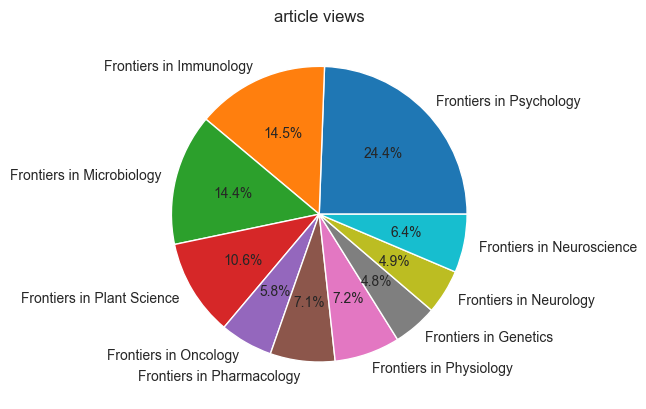

In [543]:
df_clean.nlargest(n=10, columns=['articles', 'article views', 'citations']).plot.pie(y='article views', autopct='%1.1f%%', legend=False, title="article views", ylabel="")

#### seaborn pairplot
Visualising the correllations of the cleaned dataset in a pairplot using seaborn to get a better idea of the relationshsips.

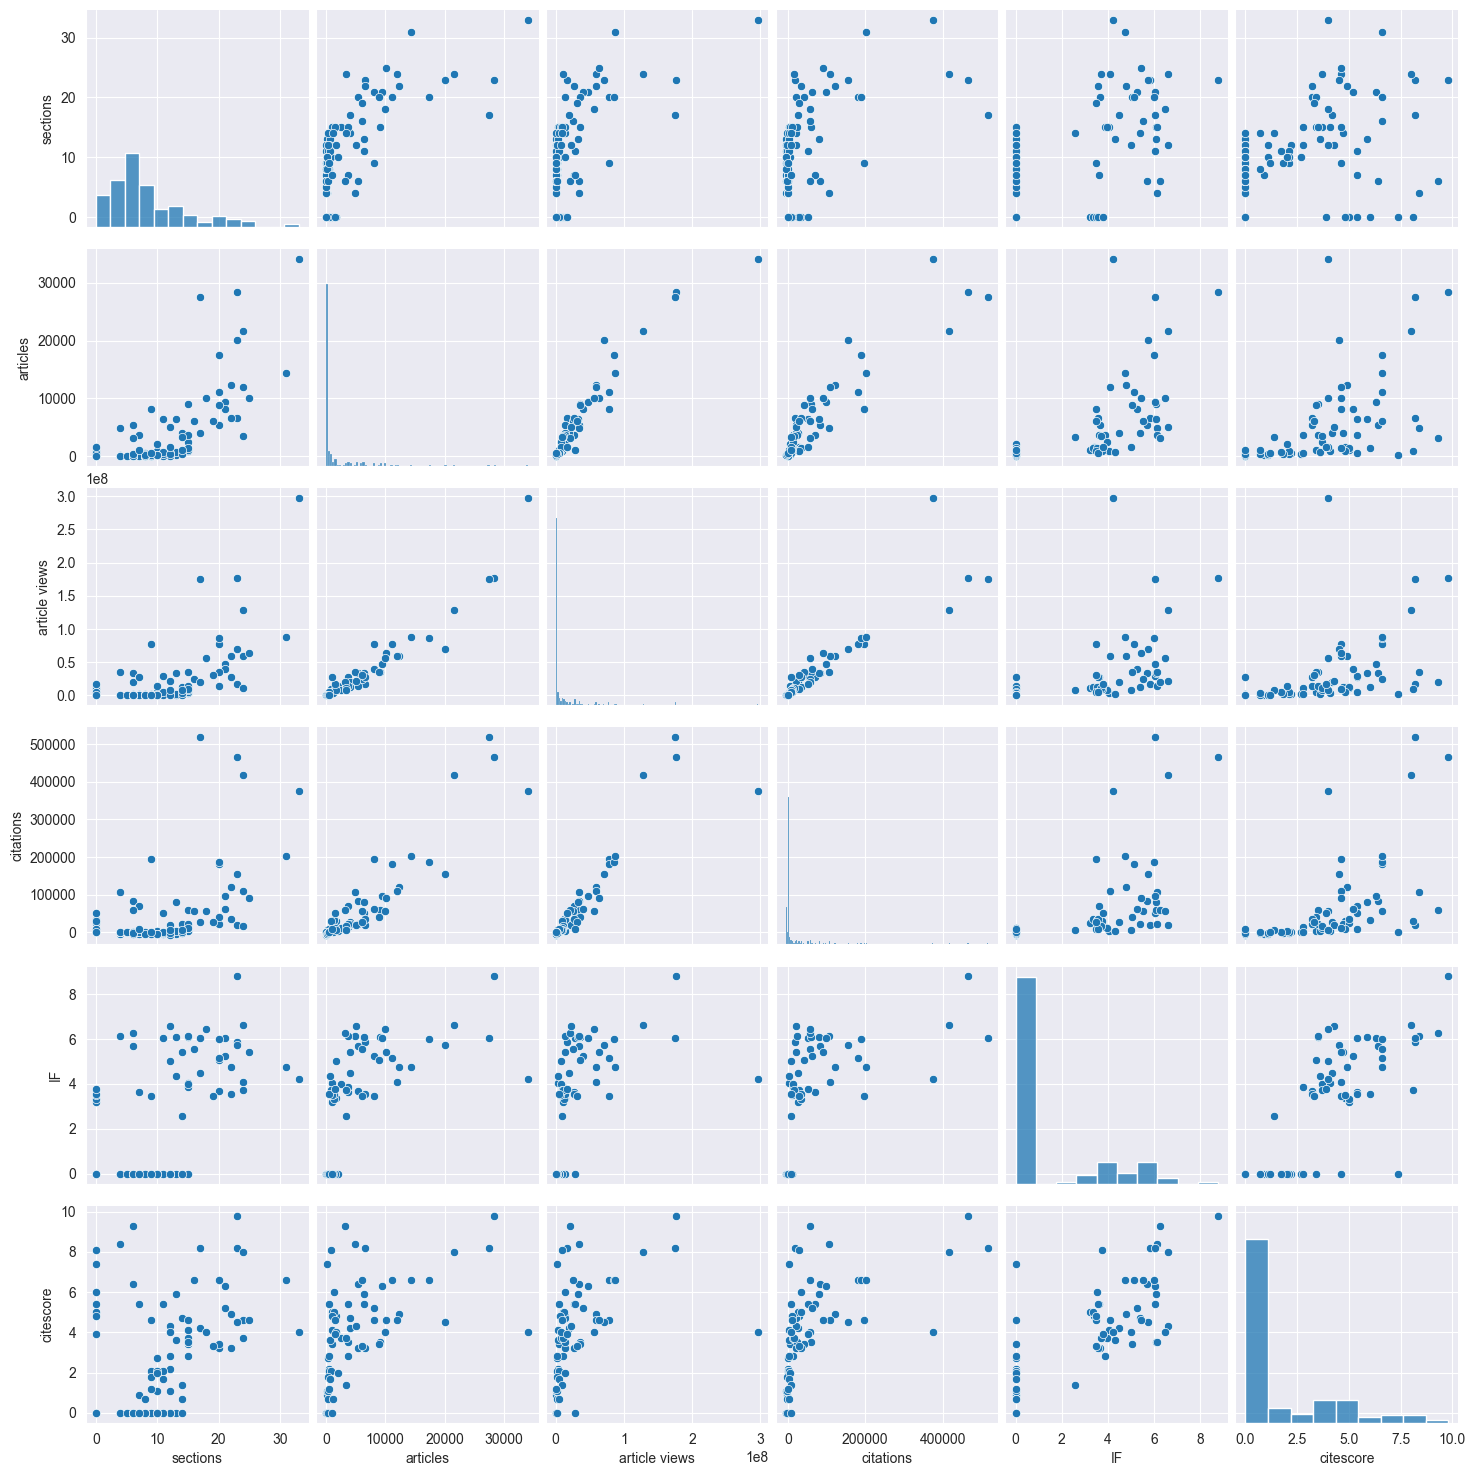

In [482]:
sns.pairplot(df_clean)

#### Histograms
The histograms show that the data is not normally distributed but has more of a Pareto distribution. This is a product of the large amount of journals with metrics of 0.

array([[<AxesSubplot:title={'center':'sections'}>,
        <AxesSubplot:title={'center':'articles'}>],
       [<AxesSubplot:title={'center':'article views'}>,
        <AxesSubplot:title={'center':'citations'}>],
       [<AxesSubplot:title={'center':'IF'}>,
        <AxesSubplot:title={'center':'citescore'}>]], dtype=object)

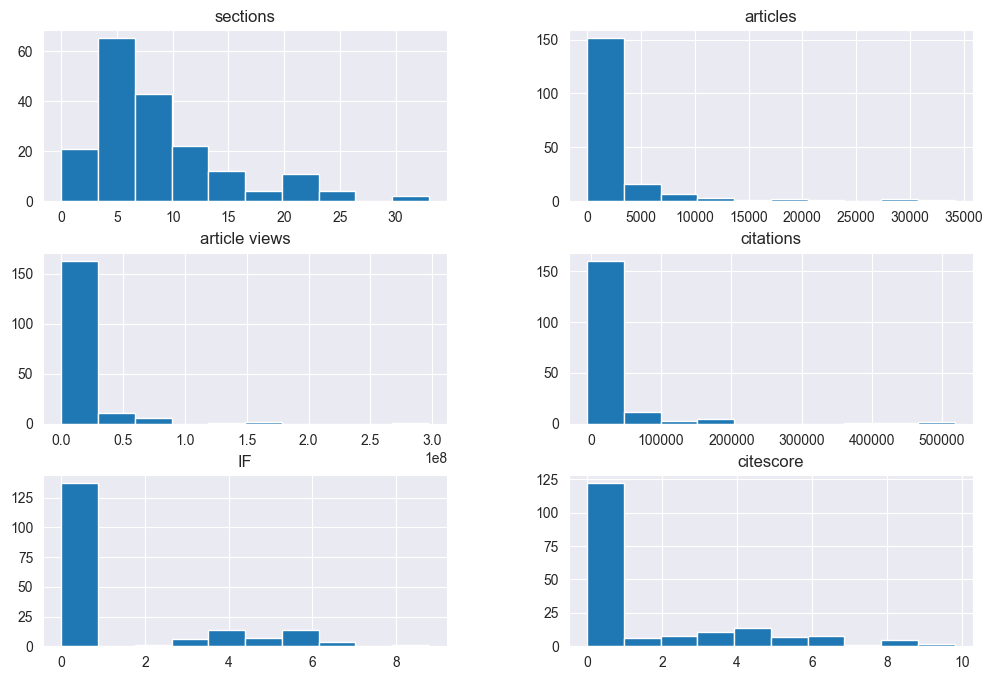

In [483]:
df_clean.hist(figsize=[12, 8])

#### Looking at the neuroscience journals

There are 19 neuroscience journals or jouranls that contain the word Neuro as part of the title. Cumulativley Frontiers in neurology is the largest with approximatley 17.7 citations per paper across all the journals and over a million cumulative citations. 

This is promising, these journals are clearly popular and should contain information needed for insight into the research question. However this data is starting to seem too high level to draw much more insight than this.

In [506]:
neuro_journals = []
for title in df_handel_nulls.index.values:
    if "Neuro" in title:
        neuro_journals.append(title)        

(19, 7)
toatal articles = 56,853.0
toatal article views = 412,236,391.0
toatal citations = 1,006,414.0
Approximatley 17.7 citations per paper.


<AxesSubplot:title={'center':'article views'}>

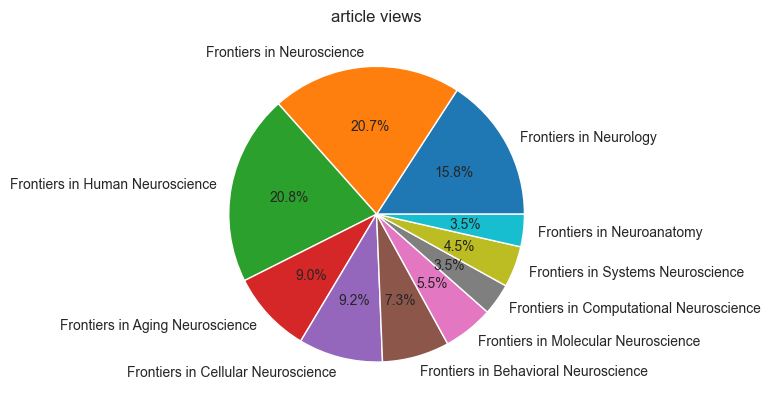

In [545]:
df_neuro = df_clean.copy()
df_neuro = df_clean.loc[neuro_journals]

print(df_neuro.shape)
print('toatal articles =', "{:,}".format(df_neuro['articles'].sum()))
print('toatal article views =', "{:,}".format(df_neuro['article views'].sum()))
print('toatal citations =',  "{:,}".format(df_neuro['citations'].sum()))
print("Approximatley %1.1f citations per paper." % (df_neuro['citations'].sum() / df_neuro['articles'].sum()))

df_neuro.nlargest(n=10, columns=['articles', 'article views', 'citations']).plot.pie(y='article views', autopct='%1.1f%%', legend=False, title="article views", ylabel="")

In [518]:
df_neuro.describe().round(decimals=1)

,sections,articles,article views,citations,IF,citescore
count,19.0,19.0,19.0,19.0,19.0,19.0
mean,4.8,2992.3,21696652.2,52969.2,3.1,4.4
std,7.0,3722.5,24899423.1,59332.2,2.1,3.0
min,0.0,36.0,0.0,0.0,0.0,0.0
25%,0.0,304.5,3654870.0,7804.5,1.6,2.0
50%,0.0,1418.0,12995203.0,29676.0,3.5,4.8
75%,7.0,4309.5,30646513.5,76078.0,3.9,6.2
max,24.0,11966.0,78142028.0,196077.0,6.3,9.3


array([[<AxesSubplot:title={'center':'sections'}>,
        <AxesSubplot:title={'center':'articles'}>],
       [<AxesSubplot:title={'center':'article views'}>,
        <AxesSubplot:title={'center':'citations'}>],
       [<AxesSubplot:title={'center':'IF'}>,
        <AxesSubplot:title={'center':'citescore'}>]], dtype=object)

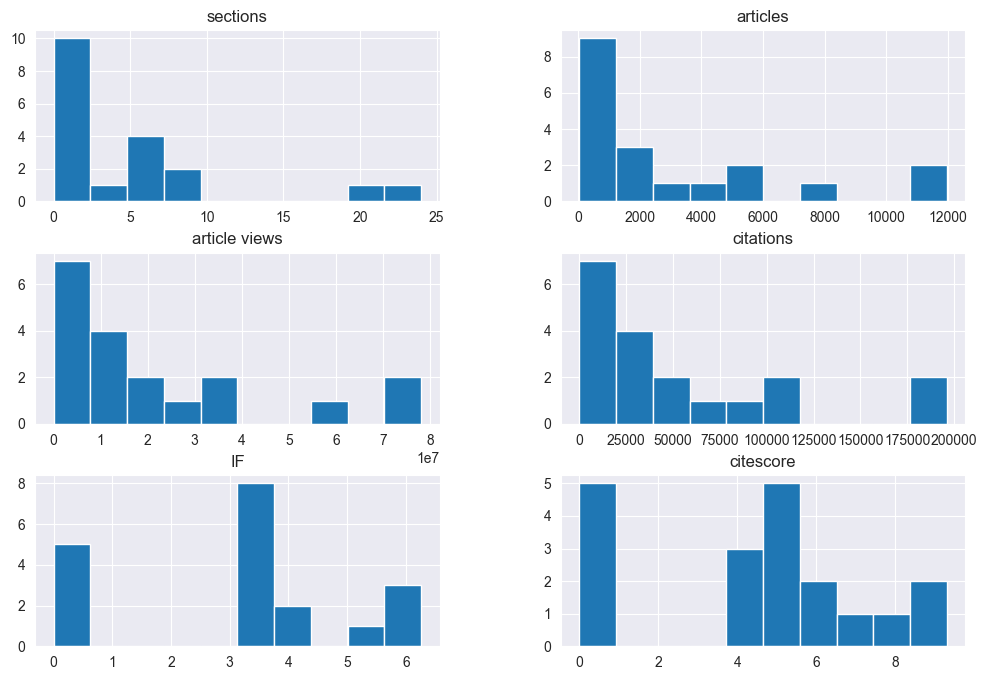

In [509]:
df_neuro.hist(figsize=[12, 8])

#### Correlation in the neuroscience journals

The correlation is very high between these journals which means that insights for one journal based on these metrics are likely to be generalisable to the other journals. However we are only working with much fewer data points.

In [520]:
df_neuro.corr().round(decimals=1)

,sections,articles,article views,citations,IF,citescore
sections,1.0,0.9,0.8,0.7,0.3,0.1
articles,0.9,1.0,1.0,0.9,0.6,0.4
article views,0.8,1.0,1.0,1.0,0.6,0.4
citations,0.7,0.9,1.0,1.0,0.6,0.5
IF,0.3,0.6,0.6,0.6,1.0,0.9
citescore,0.1,0.4,0.4,0.5,0.9,1.0


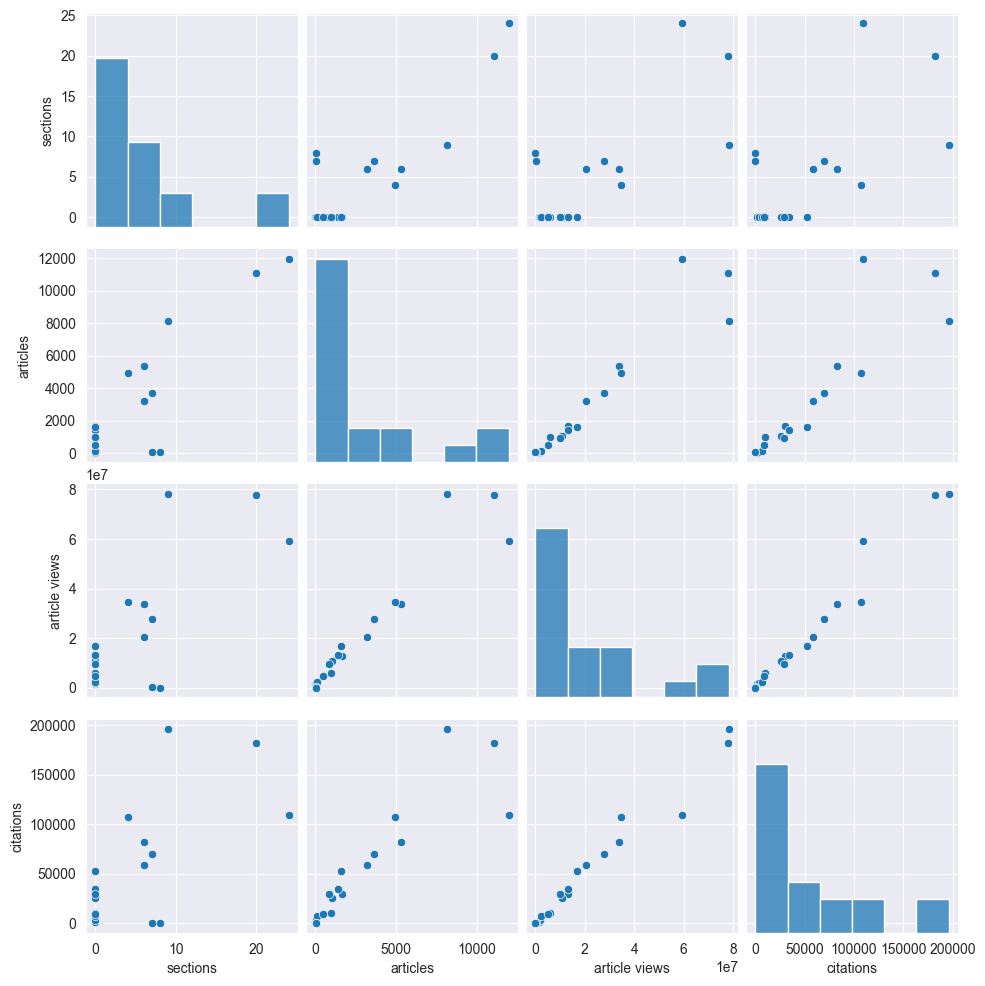

In [515]:
sns.pairplot(df_neuro[['sections', 'articles', 'article views', 'citations']])